<a href="https://colab.research.google.com/github/asavari381/Netflix-Stock-Price-Prediction/blob/main/LSTM_NFLX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import yfinance as yf


### Model Input

[*********************100%***********************]  1 of 1 completed


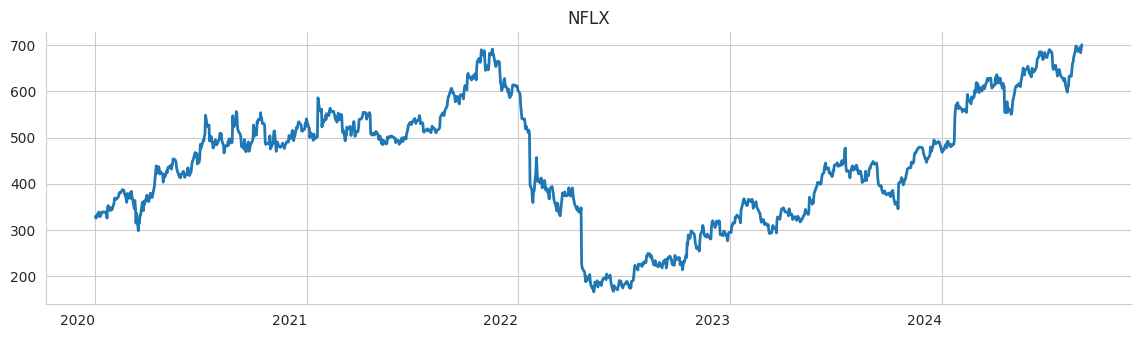

In [3]:
# set up the random state
sns.set_style('whitegrid')
np.random.seed(42)

start_date = datetime(2020,1,1)
end_date = datetime(2024,8,31)
stock_symbol = 'NFLX'

# Download stock data from yahoo finance
stocks = yf.download('NFLX',start_date ,end_date)
price_type = 'Adj Close'
stock_price = pd.DataFrame(stocks[price_type])

ax = stock_price.plot(title = stock_symbol, legend=False, linewidth = 2, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [4]:
scaler = MinMaxScaler()
stocks_scaled = pd.Series(scaler.fit_transform(stock_price.values.reshape(-1, 1)).squeeze(),
                         index = stock_price.index)

stocks_scaled.describe()

,0
count,1174.000000
mean,0.525505
std,0.246726
min,0.000000
25%,0.343812
50%,0.559909
75%,0.699919
max,1.000000


### Model Processing



In [5]:
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

window_size = 1
X, y = create_univariate_rnn_data(stocks_scaled, window_size = window_size)
print(X.head())
# Train-test split
X_train = X[:'2022'].values.reshape(-1, window_size, 1)
y_train = y[:'2022']
y_train.shape

n_obs, window_size, n_features = X_train.shape
# keep the last year for testing
X_test = X['2023':].values.reshape(-1, window_size, 1)
y_test = y['2023':]

                   0
Date                
2020-01-03  0.305507
2020-01-06  0.298198
2020-01-07  0.316760
2020-01-08  0.307264
2020-01-09  0.323171


In [6]:
X_train.shape

(755, 1, 1)

In [7]:
from keras.optimizers import Adam

def create_RNN(hidden_units, dense_units, input_shape, activation):
    optimizer = Adam(learning_rate=0.001)
    model = Sequential() # clarify hidden states vs hidden layers
    model.add(LSTM(units=hidden_units, return_sequences=True, input_shape=input_shape, activation="leaky_relu"))
    model.add(Dropout(0.1))
    model.add(LSTM(units=25, return_sequences=True, activation="leaky_relu"))
    model.add(Dropout(0.1))
    model.add(LSTM(units=5, return_sequences=True, activation = "leaky_relu"))
    model.add(Dropout(0.1))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Create model and train
lstm = create_RNN(hidden_units = 50, dense_units = 1, input_shape = (window_size, n_features),
                   activation=['tanh', 'tanh'])
lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 25)               │           7,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 25)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1, 5)                │             620 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 5)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1, 1)                │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,626 (72.76 KB)

 Trainable params: 18,626 (72.76 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
lstm_training = lstm.fit(X_train,
                       y_train,
                       epochs = 50,
                       validation_data = (X_test, y_test),
                       verbose=1)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.2980 - val_loss: 0.3526
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2634 - val_loss: 0.3077
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2207 - val_loss: 0.2501
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1693 - val_loss: 0.1614
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0978 - val_loss: 0.0452
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0437 - val_loss: 0.0175
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0385 - val_loss: 0.0193
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0340 - val_loss: 0.0148
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0282 - val_loss: 0.0124
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0297 - val_loss: 0.0089
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0280 - val_loss: 0.0067
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0249 - val_

### Model Output

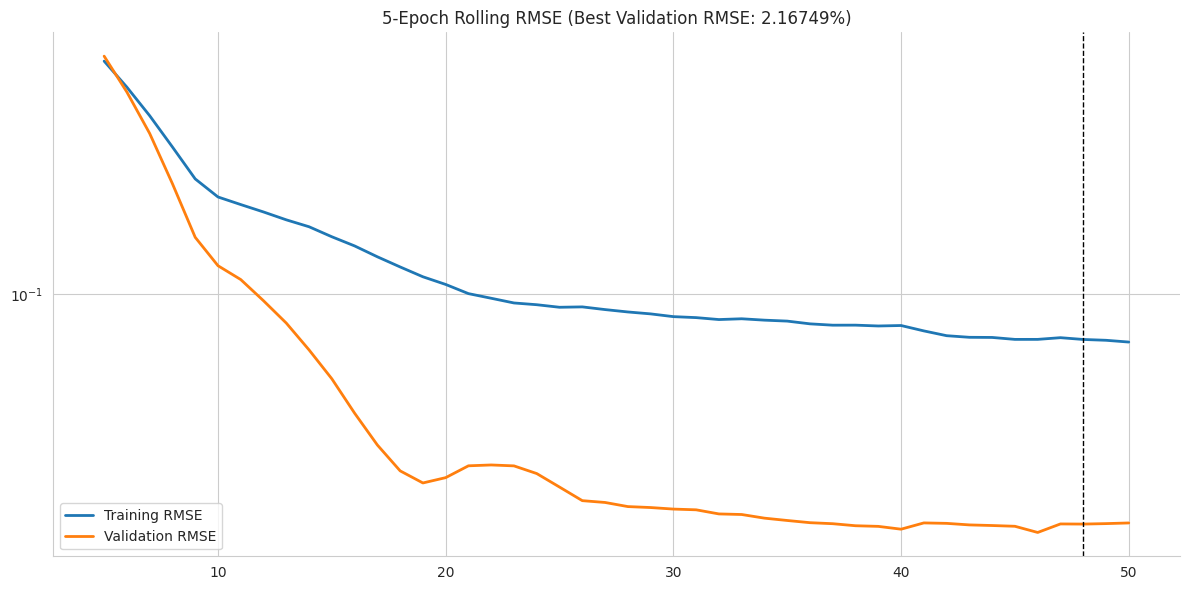

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.5%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()

In [10]:
train_rmse_scaled = np.sqrt(lstm.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(lstm.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE (scaled): {train_rmse_scaled:.4f} | Test RMSE (scaled): {test_rmse_scaled:.4f}')

Train RMSE (scaled): 0.0264 | Test RMSE (scaled): 0.0225


In [11]:
train_predict_scaled = lstm.predict(X_train)
test_predict_scaled = lstm.predict(X_test)
print(train_predict_scaled.shape)
train_ic = spearmanr(y_train, train_predict_scaled.reshape(755))[0]
test_ic = spearmanr(y_test, test_predict_scaled.reshape(418))[0]
print(f"Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}")
print(type(train_ic))

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
(755, 1, 1)
Train IC: 0.9901 | Test IC: 0.9946
<class 'numpy.float64'>


In [12]:
#reshaping from (755, 1, 1) to (755, 1)
train_predict_scaled = train_predict_scaled.reshape(755, 1)
test_predict_scaled = test_predict_scaled.reshape(418, 1)
# print(train_predict_scaled.shape)

**Rescale Predictions**

In [13]:
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled[:, 0].reshape(-1, 1)).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled[:, 0].reshape(-1, 1)).squeeze(), index=y_test.index))
# use inverse_transform to convert the scaled data back to its original scale.
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

In [14]:
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
print(f"Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}")

Train RMSE: 14.10 | Test RMSE: 12.05


In [15]:
stock_price['Train Predictions'] = train_predict
stock_price['Test Predictions'] = test_predict

to_be_merged = pd.concat([train_predict.to_frame('predictions').assign(data='Train'),
                   test_predict.to_frame('predictions').assign(data='Test')])

stock_price = pd.merge(stock_price, to_be_merged, how='inner', on = 'Date')
# remove the suffixes brought by pd.merge()
stock_price.columns = stock_price.columns.str.rstrip('_x').str.rstrip('_y')

### Visualization

In [16]:
stock_price

,Adj Close,Train Predictions,Test Predictions,predictions,data
Date,,,,,
2020-01-03,325.899994,330.118988,NaN,330.118988,Train
2020-01-06,335.829987,326.293640,NaN,326.293640,Train
2020-01-07,330.750000,335.826813,NaN,335.826813,Train
2020-01-08,339.260010,330.998383,NaN,330.998383,Train
2020-01-09,335.660004,339.159943,NaN,339.159943,Train
...,...,...,...,...,...
2024-08-26,688.440002,NaN,663.425171,663.425171,Test
2024-08-27,695.719971,NaN,664.205200,664.205200,Test
2024-08-28,683.840027,NaN,667.396362,667.396362,Test


,Adj Close,Train Predictions,Test Predictions,pred,data
Date,,,,,
2020-01-03,325.899994,330.118988,NaN,330.118988,Train
2020-01-06,335.829987,326.293640,NaN,326.293640,Train
2020-01-07,330.750000,335.826813,NaN,335.826813,Train
2020-01-08,339.260010,330.998383,NaN,330.998383,Train
2020-01-09,335.660004,339.159943,NaN,339.159943,Train


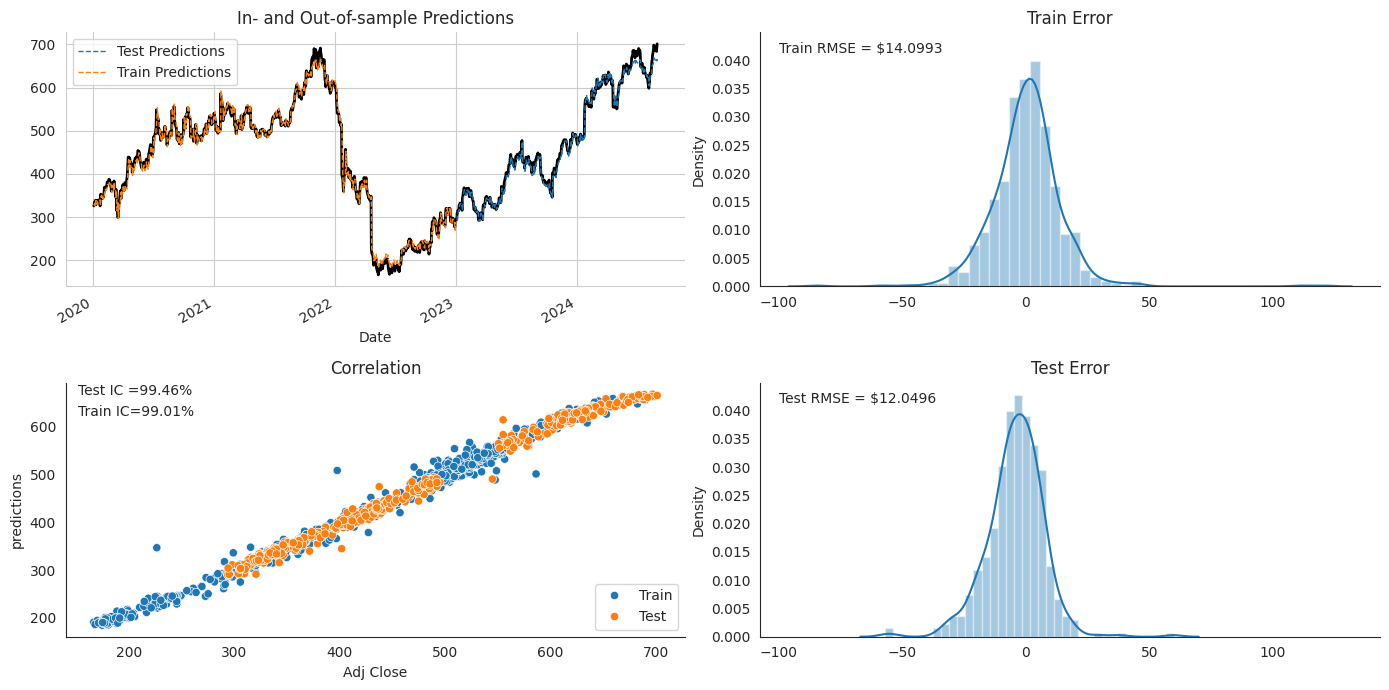

In [17]:
fig=plt.figure(figsize=(14,7))
ax1 = plt.subplot(221)
stock_price.loc['2020':, price_type].plot(lw=2, ax=ax1, c='k')
stock_price.loc['2020':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
stock_price.columns.values[3] = "pred"

ax1.set_title('In- and Out-of-sample Predictions')
with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x = price_type, y = 'predictions', data = stock_price, hue = 'data', ax = ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')

    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE = ${train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE = ${test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
stock_price.head()